# 3 - Bike Sharing Prediction

## Task description:

* **Training data**: whole 2011 and first 3 quarters of 2012.
* **Test data**: 4th quarter of 2012.  Do not fit your models with these data! They should just be used to see how good/bad your model predictions are.
* **Error metric**: R2 score (scikit-learn's default for regression).
* **Features to use**: at least the ones present in the data (except for cnt). Do not use both casual and registered columns, as cnt=casual+registered (you may use one, but not both). Additionally, you can use other sources of data you deem appropriate to predict from extra features.

## Exploratory Data Analysis (descriptive analytics) (4 points)

The first step of the analysis is to get familiar with the data. After importing the datasets we perform some analysis to have a general idea about the data. 
* **.head**: to understand the columns of the datasets
* **.describe**: to understand the distribution of the data 

In [1]:
# For the purposes of the presentation \ exercise Warnings turned off.
import warnings

warnings.filterwarnings("ignore")

import zipfile
import requests
import io
import re
import pandas as pd
import numpy as np

import dask
import dask.dataframe as dd
import datetime
import time

start = time.time()


def print_time(sec):
    if (time.strftime("%H", time.localtime(sec))) == "01":
        hr = "00"
    else:
        hr = time.strftime("%H", time.localtime(sec))

    return hr + time.strftime(":%M:%S", time.localtime(sec))


print(print_time(start))

14:51:42


In order to predict the feature cnt we need to delete casual and registered (being these variable sub classes of cnt)

In [2]:
# !pip install kaggle
# !kaggle datasets list -s bike-sharing-dataset
!kaggle datasets download -d marklvl/bike-sharing-dataset --force


  0%|          | 0.00/273k [00:00<?, ?B/s]
100%|##########| 273k/273k [00:00<00:00, 3.60MB/s]


In [3]:
from dask.distributed import Client, progress, LocalCluster

cluster = LocalCluster()
client = Client(n_workers=4)  # , threads_per_worker=2, memory_limit='4GB')
client

Client Scheduler: tcp://127.0.0.1:52144 Dashboard: http://127.0.0.1:52145/status,Cluster Workers: 4 Cores: 4 Memory: 8.51 GB


In [4]:
from dask import delayed
from io import BytesIO

zfname = "bike-sharing-dataset.zip"

with zipfile.ZipFile(zfname) as zfile:
    for name in zfile.namelist():

        if re.search(r"\.zip$", name) is not None:
            # We have a zip within a zip
            zfiledata = BytesIO(zfile.read(name))
            with zipfile.ZipFile(zfiledata) as zfile2:
                zfile2.extract("day.csv")
                zfile2.extract("hour.csv")

day = dd.read_csv("day.csv")

hour_type = {
    "instant": int,
    "dteday": str,
    "season": "category",
    "yr": "category",
    "mnth": "category",
    "hr": "category",
    "holiday": "category",
    "weekday": "category",
    "workingday": "category",
    "weathersit": "category",
    "temp": float,
    "atemp": float,
    "hum": float,
    "windspeed": float,
    "cnt": int,
}

hour = dd.read_csv("hour.csv", dtype=hour_type)
hour = hour.drop("casual", axis=1)
hour = hour.drop("registered", axis=1)

df_results = pd.DataFrame(
    columns=["Model", "score_cv", "r^2", "params", "elapsed_time"]
)

type(hour)

dask.dataframe.core.DataFrame

In [5]:
hour.dtypes

instant          int32
dteday          object
season        category
yr            category
mnth          category
hr            category
holiday       category
weekday       category
workingday    category
weathersit    category
temp           float64
atemp          float64
hum            float64
windspeed      float64
cnt              int32
dtype: object

In [6]:
hour.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("ggplot")

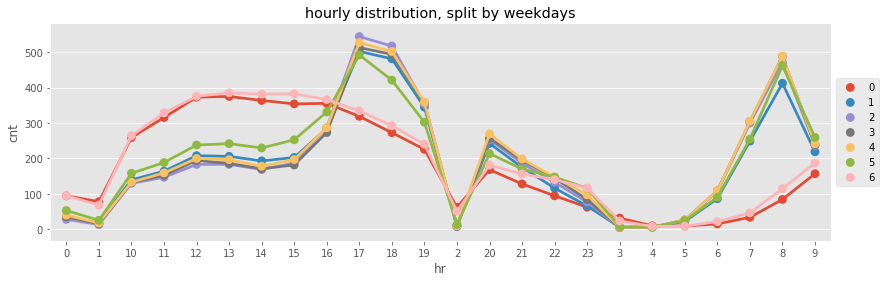

In [8]:
# here we plot the hourly distribution of the bike ride count by weekdays, to understand daily usage patterns
plt.figure(figsize=(14, 4))
weekday_hr_gb = (
    hour.groupby(["weekday", "hr"]).mean()["cnt"].reset_index(drop=False).compute()
)
sns.pointplot(x="hr", y="cnt", hue="weekday", data=weekday_hr_gb)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.title("hourly distribution, split by weekdays")
plt.show()

We notice the following: 
- weekdays - peaks are mornings and evenings
- weekends - peaks are during the day

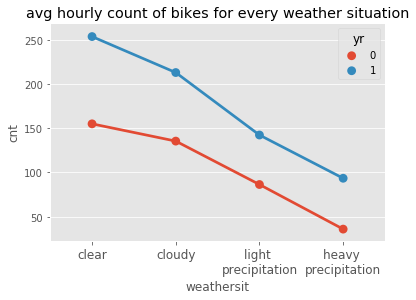

In [9]:
weathersit_gb = (
    hour.groupby(["weathersit", "yr"]).mean()["cnt"].reset_index(drop=False).compute()
)
weathersit_gb["yr"].replace([0, 1], [2011, 2012], inplace=True)
sns.pointplot(hue="yr", x="weathersit", y="cnt", data=weathersit_gb)
plt.title("avg hourly count of bikes for every weather situation")
plt.xticks(
    range(4),
    ["clear", "cloudy", "light \nprecipitation", "heavy \nprecipitation"],
    rotation=0,
    fontsize="12",
)
plt.show()

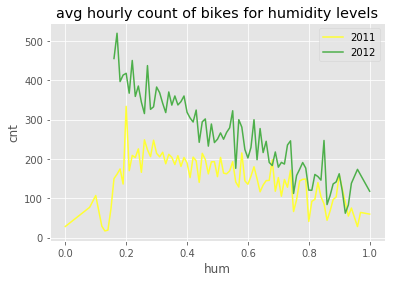

In [10]:
hum_gb = hour.groupby(["hum", "yr"]).mean()["cnt"].reset_index(drop=False).compute()
hum_gb["yr"].replace([0, 1], [2011, 2012], inplace=True)
sns.lineplot("hum", "cnt", hue="yr", data=hum_gb, palette="Set1_r")
# sb.lineplot('hum','cnt',data=hum_gb[hum_gb['yr']==2012])
plt.title("avg hourly count of bikes for humidity levels")
plt.legend([2011, 2012])
plt.show()

We have reasons to suspect correlation. The more humid it is, the less bikes are being rented out in 2011 the trend looks a bit different - where humidity is very low also less bikes are being used together with year it has some connection to our target value


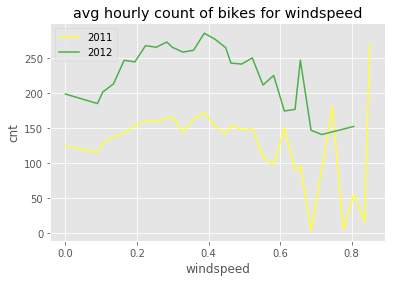

In [11]:
windspeed_gb = (
    hour.groupby(["windspeed", "yr"]).mean()["cnt"].reset_index(drop=False).compute()
)
windspeed_gb["yr"].replace([0, 1], [2011, 2012], inplace=True)
sns.lineplot("windspeed", "cnt", hue="yr", data=windspeed_gb, palette="Set1_r")
plt.title("avg hourly count of bikes for windspeed")
plt.legend([2011, 2012])
plt.show()

As expected, there is no significant trend here to be seen

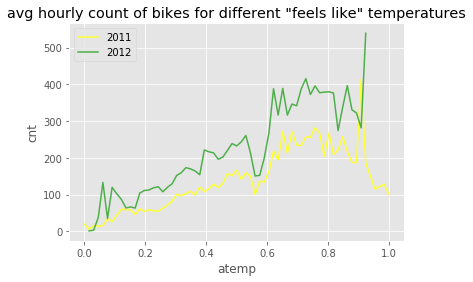

In [12]:
atemp_gb = hour.groupby(["atemp", "yr"]).mean()["cnt"].reset_index(drop=False).compute()
atemp_gb["yr"].replace([0, 1], [2011, 2012], inplace=True)
sns.lineplot(hue="yr", x="atemp", y="cnt", data=atemp_gb, palette="Set1_r")
plt.title('avg hourly count of bikes for different "feels like" temperatures')
plt.legend([2011, 2012])
plt.show()

We see that the warmer it feels, the more bikes are being used but only up to a certain temperature. When it starts feeling very warm, less bikes are being rented out

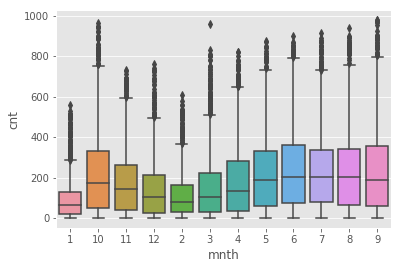

In [13]:
# here we will plot the count of rides per month, while also representing its distribution
ax = sns.boxplot(x="mnth", y="cnt", data=hour.compute())

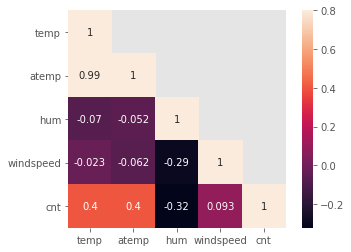

In [14]:
# Here we plot the correlations among variables through a heatmap, which will be useful during the feature engineering phase.
corrMatt = hour[["temp", "atemp", "hum", "windspeed", "cnt"]].compute().corr()

mask = np.array(corrMatt)
# Turning the lower-triangle of the array to false
mask[np.tril_indices_from(mask)] = False
fig, ax = plt.subplots()
sns.heatmap(corrMatt, mask=mask, vmax=0.8, square=True, annot=True, ax=ax)

plt.show()

## Data Cleaning
Here we star with cleaning the data. 
* **Step 1:** We split the variables into categorical and numerical to understand what variable can undergo what transformation
* **Step 2:** We check for NAs
* **Step 3:** We plot the different variables as boxplots to get a sense of the outlier distribution. 

### Features class 

In order to improve the quality of the predictions, it is possible to transform wrongly encoded numerical feature in categorical ones. In this case "hr", "weekday", "mnth", "season", "weathersit", "holiday", "workingday" are encoded as numerical feature but they are clearly categorical. 

In [15]:
# here we split the variables into categorical and numerical under two different lists
from numpy import math
import numpy as np

catfeats = list(hour.select_dtypes(include=["category"]).columns.values)
numfeats = list(hour.select_dtypes(include=[np.number]).columns.values)

In [16]:
print(catfeats)

['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit']


In [17]:
print(numfeats)

['instant', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']


In [18]:
hour.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


### NAs

As it is possible to notice there are not NAs in the dataset. Therefore, no further action is required. 

In [19]:
# here we go hunting for NAs
for column in hour.columns:
    NAs = hour[column].isnull().sum().compute()
    print(column + " " + str(NAs))

instant 0
dteday 0
season 0
yr 0
mnth 0
hr 0
holiday 0
weekday 0
workingday 0
weathersit 0
temp 0
atemp 0
hum 0
windspeed 0
cnt 0


### Outliers 
Here we have a look on the outliers. We will however not exclude any, as after iterating, we understood that we get better results withouth doing that. 

In [20]:
def show_outlier():
    fig, axes = plt.subplots(nrows=2, ncols=2)
    fig.set_size_inches(12, 10)
    sns.boxplot(data=hour.compute(), y="cnt", orient="v", ax=axes[0][0])
    sns.boxplot(data=hour.compute(), y="cnt", x="season", orient="v", ax=axes[0][1])
    sns.boxplot(data=hour.compute(), y="cnt", x="hr", orient="v", ax=axes[1][0])
    sns.boxplot(data=hour.compute(), y="cnt", x="workingday", orient="v", ax=axes[1][1])

    axes[0][0].set(ylabel="Count", title="Box Plot On Count")
    axes[0][1].set(
        xlabel="Season", ylabel="Count", title="Box Plot On Count Across Season"
    )
    axes[1][0].set(
        xlabel="Hour Of The Day",
        ylabel="Count",
        title="Box Plot On Count Across Hour Of The Day",
    )
    axes[1][1].set(
        xlabel="Working Day",
        ylabel="Count",
        title="Box Plot On Count Across Working Day",
    )

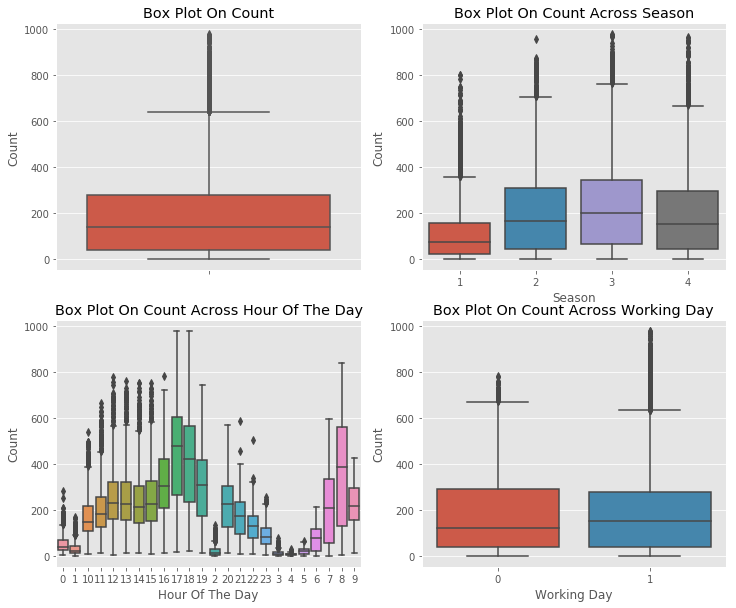

In [21]:
show_outlier()

## Feature Engineering
Here we switch the original columns, with some dummy ones, so to fit the format needs of our algorithms. 

In [22]:
hour.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


In [23]:
# !pip install dask_ml
import dask_ml.preprocessing as dml

dummy_columns = [
    "hr",
    "weekday",
    "mnth",
    "season",
    "weathersit",
    "holiday",
    "workingday",
    "yr",
]

hour = hour.categorize(dummy_columns)
de = dml.DummyEncoder(dummy_columns)
hour = de.fit_transform(hour)

In [24]:
hour.columns

Index(['instant', 'dteday', 'temp', 'atemp', 'hum', 'windspeed', 'cnt', 'hr_0',
       'hr_1', 'hr_10', 'hr_11', 'hr_12', 'hr_13', 'hr_14', 'hr_15', 'hr_16',
       'hr_17', 'hr_18', 'hr_19', 'hr_2', 'hr_20', 'hr_21', 'hr_22', 'hr_23',
       'hr_3', 'hr_4', 'hr_5', 'hr_6', 'hr_7', 'hr_8', 'hr_9', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'mnth_1', 'mnth_10', 'mnth_11', 'mnth_12', 'mnth_2',
       'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9',
       'season_1', 'season_2', 'season_3', 'season_4', 'weathersit_1',
       'weathersit_2', 'weathersit_3', 'weathersit_4', 'holiday_0',
       'holiday_1', 'workingday_0', 'workingday_1', 'yr_0', 'yr_1'],
      dtype='object')

In [25]:
# drop also the variables 'instant' since it is irrelevant
hour = hour.drop("instant", axis=1)

## Machine Learning (predictive analytics) (5 points)

In this part, we start applying the different models we want to apply. The order of this subchapter is the following:
* **Step 1: Train and test split**
* **Step 2: Regression model**
* **Step 3: Random forest**
* **Step 4: XGBoost**
* **Step 5: Combining models**
* **Step 6: Pipeline**


### Training test split

In [26]:
# here we create the training set from the complete dataset we have, using the date as filtering item
# hour_m = hour.compute()
X_train = hour.loc[hour["dteday"] < "2012-10-1"]
X_train = X_train.drop("cnt", axis=1)
X_train = X_train.drop("dteday", axis=1)
X_train.head()

,temp,atemp,hum,windspeed,hr_0,hr_1,hr_10,hr_11,hr_12,hr_13,...,weathersit_1,weathersit_2,weathersit_3,weathersit_4,holiday_0,holiday_1,workingday_0,workingday_1,yr_0,yr_1
0,0.24,0.2879,0.81,0.0,1,0,0,0,0,0,...,1,0,0,0,1,0,1,0,1,0
1,0.22,0.2727,0.80,0.0,0,1,0,0,0,0,...,1,0,0,0,1,0,1,0,1,0
2,0.22,0.2727,0.80,0.0,0,0,0,0,0,0,...,1,0,0,0,1,0,1,0,1,0
3,0.24,0.2879,0.75,0.0,0,0,0,0,0,0,...,1,0,0,0,1,0,1,0,1,0
4,0.24,0.2879,0.75,0.0,0,0,0,0,0,0,...,1,0,0,0,1,0,1,0,1,0


In [27]:
# here we create the test set from the complete dataset we have, using the date as filtering item
X_test = hour.loc[hour["dteday"] >= "2012-10-1"]
X_test = X_test.drop("cnt", axis=1)
X_test = X_test.drop("dteday", axis=1)
X_test.head()

,temp,atemp,hum,windspeed,hr_0,hr_1,hr_10,hr_11,hr_12,hr_13,...,weathersit_1,weathersit_2,weathersit_3,weathersit_4,holiday_0,holiday_1,workingday_0,workingday_1,yr_0,yr_1
15427,0.46,0.4545,0.88,0.0896,1,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,1
15428,0.46,0.4545,0.88,0.0000,0,1,0,0,0,0,...,0,1,0,0,1,0,0,1,0,1
15429,0.46,0.4545,0.88,0.0000,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,1
15430,0.46,0.4545,0.88,0.0000,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,1
15431,0.46,0.4545,0.88,0.1045,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,1


In [28]:
y_train = hour.loc[hour["dteday"] < "2012-10-1"]["cnt"]
type(y_train)

dask.dataframe.core.Series

In [29]:
y_test = hour.loc[hour["dteday"] >= "2012-10-1"]["cnt"]
type(y_test)

dask.dataframe.core.Series

## Regression Model
Here we run our regression model, which is the first model we want to try as if with such a simple one we get good results, we would prefer it over more complex ones. 

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# !pip install dask_ml

In [31]:
# Create linear regression object

# from sklearn.externals import joblib # Deprecated. import joblib recommended.
# !pip install joblib
# Tried Dask Linear Regression with Pandas DF and with Dask DF - did not work.
# Tried dask parallel backend with normal Linear Regression. Worked so using this.
import joblib

regr = linear_model.LinearRegression()

mod_start = time.time()
with joblib.parallel_backend("dask"):
    regr.fit(X_train, y_train)
    y_pred_rm = regr.predict(X_test)
    r2_rm = r2_score(y_test, y_pred_rm)

    print(r2_rm.round(2))
mod_elapsed = time.time() - mod_start

df_results.loc[df_results.shape[0]] = [
    "LinearRegression",
    0,
    r2_rm.round(2),
    "",
    print_time(mod_elapsed),
]

0.63


In [32]:
# Could not do cross_val_score with DASK. or Dask DF
# cross_val with dask parallel also did not work.

mod_start = time.time()
accuracy_rm = cross_val_score(
    estimator=regr, X=X_train.compute(), y=y_train.compute(), cv=5
)
print(accuracy_rm[1].round(2))

r2_rm = r2_score(y_test.compute(), y_pred_rm)
r2_rm.round(2)

mod_elapsed = time.time() - mod_start

df_results.loc[df_results.shape[0]] = [
    "LinearRegression_cross_Val",
    accuracy_rm[1].round(2),
    r2_rm.round(2),
    "",
    print_time(mod_elapsed),
]

0.68


Lets compare the distribution of train and test results. the distribution of train and test looks very different. It confirms visually that our model has not predicted really in a proper way cnt.

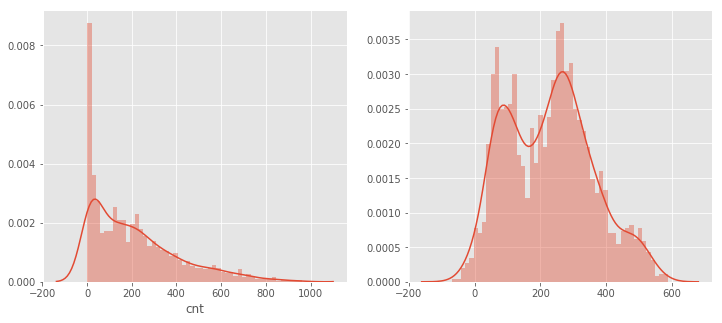

In [33]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12, 5)
sns.distplot(y_test, ax=ax1, bins=50)
sns.distplot((y_pred_rm), ax=ax2, bins=50)

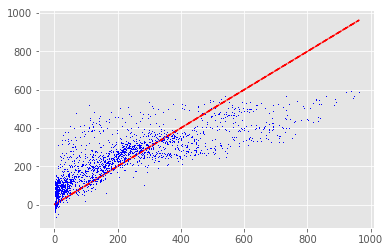

In [34]:
plt.plot(y_test.compute(), y_test.compute(), "r--", y_test.compute(), y_pred_rm, "b,")
plt.show()

### Random forest
Here we run out random forest model. Also, using grid_search, we find the best parameters for this model. 

In [35]:
# Grid Search
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

print_time(time.time())

'14:52:07'

In [36]:
df_results

,Model,score_cv,r^2,params,elapsed_time
0,LinearRegression,0,0.63,,00:00:01
1,LinearRegression_cross_Val,0.68,0.63,,00:00:00


In [37]:
regressor = RandomForestRegressor()
parameters = [
    {"n_estimators": [150, 200, 250, 300], "max_features": ["auto", "sqrt", "log2"]}
]
grid_search_rfr = GridSearchCV(estimator=regressor, param_grid=parameters, cv=3)

mod_start = time.time()
# Create linear regression object
with joblib.parallel_backend("dask"):
    grid_search_rfr.fit(X_train.compute(), y_train.compute())
    best_parameters = grid_search_rfr.best_params_
    best_accuracy = grid_search_rfr.best_score_
    y_pred_rfr = grid_search_rfr.best_estimator_.predict(X_test.compute())

r2_rfr = r2_score(y_test.compute(), y_pred_rfr)
r2_rfr.round(2)

mod_elapsed = time.time() - mod_start

df_results.loc[df_results.shape[0]] = [
    "RandomForestRegressor",
    best_accuracy.round(2),
    r2_rfr.round(2),
    best_parameters,
    print_time(mod_elapsed),
]
df_results

,Model,score_cv,r^2,params,elapsed_time
0,LinearRegression,0,0.63,,00:00:01
1,LinearRegression_cross_Val,0.68,0.63,,00:00:00
2,RandomForestRegressor,0.72,0.85,"{'max_features': 'auto', 'n_estimators': 200}",00:05:47


In [38]:
feature_importance = grid_search_rfr.best_estimator_.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())

Here we plot the variable importance to get a grasp of what the most important ones are, and the relative importance of each one as well.

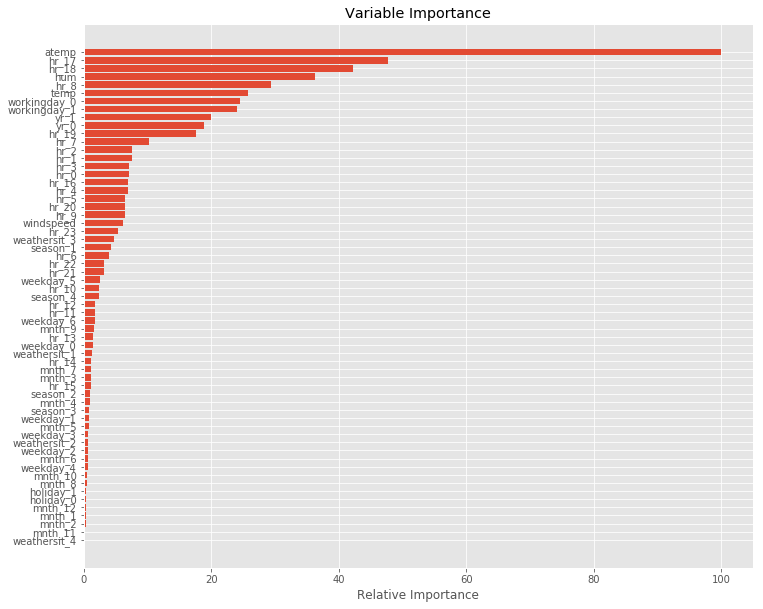

In [39]:
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
plt.figure(figsize=(12, 10))
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()

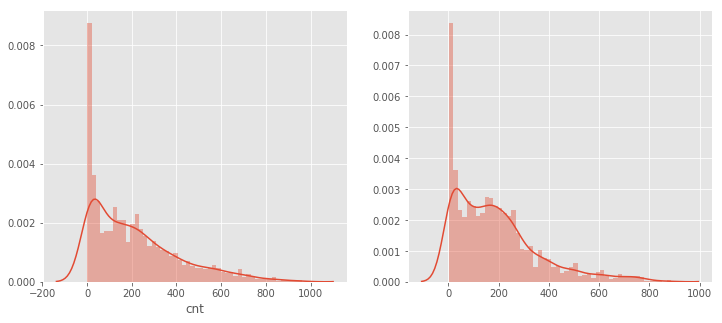

In [40]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12, 5)
sns.distplot((y_test), ax=ax1, bins=50)
sns.distplot((y_pred_rfr), ax=ax2, bins=50)

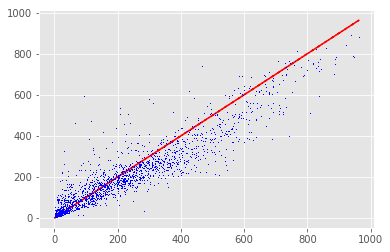

In [41]:
plt.plot(y_test.compute(), y_test.compute(), "r--", y_test.compute(), y_pred_rfr, "b,")
plt.show()

### XGBoost
Here we run the XGBoost model. 

In [42]:
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [43]:
# tuning Hyperparameters - XGBoost with GridSearch using Dask Parallel
# GridSearchCV was timing on DASK out with more parameters, so just reduced to one set.
# Dask GridSearchCV was broken by a release of sklearn and will not import..
# import dask-searchcv as dsv

parameters_xgb = [
    {"n_estimators": [1000], "max_depth": [12], "colsample_bytree": [0.8]}
]

xgb_model = xgb.XGBRegressor(
    objective="reg:linear",
    random_state=42,
    colsample_bytree=0.3,
    learning_rate=0.1,
    max_depth=5,
    alpha=10,
)

mod_start = time.time()
with joblib.parallel_backend("dask"):
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=parameters_xgb, cv=3)
    grid_search = grid_search.fit(X_train.compute(), y_train.compute())
    best_parameters_xgb = grid_search.best_params_
    y_pred_xgb = grid_search.best_estimator_.predict(X_test.compute())

    feature_importance = grid_search.best_estimator_.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    best_accuracy = grid_search.best_score_

    r2_xgb_dsk = r2_score(y_test, y_pred_xgb)


mod_elapsed = time.time() - mod_start
df_results.loc[df_results.shape[0]] = [
    "XGBRegressor_daskparallel_cv",
    best_accuracy.round(2),
    r2_xgb_dsk.round(2),
    best_parameters_xgb,
    print_time(mod_elapsed),
]
df_results

,Model,score_cv,r^2,params,elapsed_time
0,LinearRegression,0,0.63,,00:00:01
1,LinearRegression_cross_Val,0.68,0.63,,00:00:00
2,RandomForestRegressor,0.72,0.85,"{'max_features': 'auto', 'n_estimators': 200}",00:05:47
3,XGBRegressor_daskparallel_cv,0.79,0.90,"{'colsample_bytree': 0.8, 'max_depth': 12, 'n_...",00:06:02


In [44]:
print_time(time.time())

'15:03:59'

In [45]:
# #import dask_ml.model_selection as dcv
# from dask_searchcv import GridSearchCV
# import joblib
# import dask_ml.xgboost as xgboost
# import xgboost as xgb

# parameters_xgb = [
#     {
#         "objective": ["reg:linear"],
#         "random_state": [42],
#         "colsample_bytree": [0.8],
#         "learning_rate": [0.1],
#         "max_depth": [12],
#         "alpha": [10], "n_estimators": [1000]
#     }
# ]

# xgb_model = xgb.XGBRegressor(
#     objective="reg:linear",
#     random_state=42,
#     colsample_bytree=0.3,
#     learning_rate=0.1,
#     max_depth=5,
#     alpha=10,
# )

# mod_start=time.time()

# grid_search = GridSearchCV(estimator=xgb_model, param_grid=parameters_xgb, cv=3)

# grid_search = grid_search.fit(X=X_train, y=y_train)
# best_parameters_xgb = grid_search.best_params_
# # This predict failed on X_test - said mismatch error with columns. Changed to X_train for code to complete.
# #y_pred_xgb = grid_search.best_estimator_.predict(X_test)
# y_pred_xgb = grid_search.best_estimator_.predict(X_train)

# feature_importance = grid_search.best_estimator_.feature_importances_
# feature_importance = 100.0 * (feature_importance / feature_importance.max())
# best_accuracy = grid_search.best_score_

# r2_xgb_dsk = r2_score(y_train, y_pred_xgb)


# mod_elapsed = time.time()-mod_start
# df_results.loc[df_results.shape[0]] = [
#     "XGBRegressor_daskcv",
#     best_accuracy.round(2),
#     r2_xgb_dsk.round(2),
#     best_parameters_xgb, print_time(mod_elapsed)
# ]
# df_results
# df_results

# type(grid_search)

In [46]:
# Dask XGBoost
import dask_ml.xgboost as xgboost

parameters_xgb = [
    {
        "objective": "reg:linear",
        "random_state": 42,
        "colsample_bytree": 0.8,
        "learning_rate": 0.1,
        "max_depth": 12,
        "alpha": 10,
        "n_estimators": 1000,
    }
]

mod_start = time.time()
xgb_dsk = xgboost.XGBRegressor(params=parameters_xgb)

mod_start = time.time()

xgb_dsk.fit(X_train, y_train)

# Relative importance of features
y_pred_xgb_dsk = xgb_dsk.predict(X_test)
feature_importance = xgb_dsk.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())

r2_xgb_dsk = r2_score(y_test, y_pred_xgb_dsk)

accuracy_xgb_model = r2_rm.round(2)
mod_elapsed = time.time() - mod_start
df_results.loc[df_results.shape[0]] = [
    "XGBRegressor_daskml",
    r2_xgb_dsk,
    r2_xgb_dsk,
    parameters_xgb,
    print_time(mod_elapsed),
]
df_results

,Model,score_cv,r^2,params,elapsed_time
0,LinearRegression,0,0.630000,,00:00:01
1,LinearRegression_cross_Val,0.68,0.630000,,00:00:00
2,RandomForestRegressor,0.72,0.850000,"{'max_features': 'auto', 'n_estimators': 200}",00:05:47
3,XGBRegressor_daskparallel_cv,0.79,0.900000,"{'colsample_bytree': 0.8, 'max_depth': 12, 'n_...",00:06:02
4,XGBRegressor_daskml,0.661747,0.661747,"[{'objective': 'reg:linear', 'random_state': 4...",00:00:10


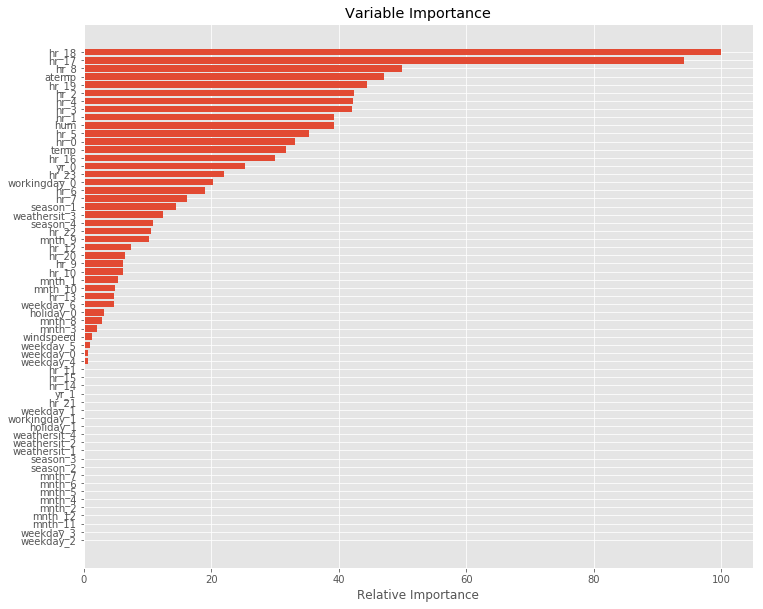

In [47]:
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
plt.figure(figsize=(12, 10))
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()

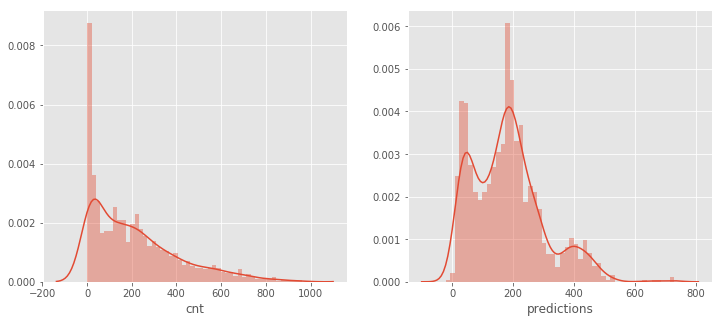

In [48]:
# here we plot to estimate the goodness of our prediction
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12, 5)
sns.distplot(y_test, ax=ax1, bins=50)
sns.distplot((y_pred_xgb_dsk), ax=ax2, bins=50)

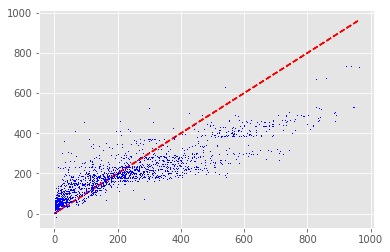

In [49]:
plt.plot(
    y_test.compute(),
    y_test.compute(),
    "r--",
    y_test.compute(),
    y_pred_xgb_dsk.compute(),
    "b,",
)
plt.show()

## Combining Models
In this section we combine some models, to see if we manage to achieve better results than the ones of the model which alone achieves the best results. We use random forest, gradient boosting and extra trees. 

In [50]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import ensemble
from sklearn.metrics import r2_score

In order to make this happen given limited computational power, we resized the dataset. This code therefore serves to  improve the running time and testing the code quality rather than given actual predictions.

In [51]:
type(hour)

dask.dataframe.core.DataFrame

In [52]:
hour_m = hour.compute()
X_train_sample = hour_m[0:688]  # one month as training data
del X_train_sample["cnt"]
del X_train_sample["dteday"]

X_test_sample = hour_m.loc[688:829]  # one week to be predicted
del X_test_sample["cnt"]
del X_test_sample["dteday"]

y_train_sample = hour_m[0:688]["cnt"]

y_test_sample = hour_m[688:829]["cnt"]

In [53]:
X_train_sample = hour.loc[0:688]  # one month as training data
X_train_sample = X_train_sample.drop("cnt", axis=1)
X_train_sample = X_train_sample.drop("dteday", axis=1)

X_test_sample = hour.loc[688:829]  # one week to be predicted
X_test_sample = X_test_sample.drop("cnt", axis=1)
X_test_sample = X_test_sample.drop("dteday", axis=1)

y_train_sample = hour.loc[0:688]["cnt"]

y_test_sample = hour.loc[688:829]["cnt"]
type(X_train_sample)

dask.dataframe.core.DataFrame

In [54]:
# here we define the models
rf = ensemble.RandomForestClassifier()
gbm = ensemble.GradientBoostingClassifier()
et = ensemble.ExtraTreesClassifier()

combo = ensemble.VotingClassifier(
    estimators=[("rf", rf), ("gbm", gbm), ("et", et)],
    voting="soft",
    weights=[3, 5, 2],
    n_jobs=10,
)
mod_start = time.time()

with joblib.parallel_backend("dask"):
    combo.fit(X_train_sample, y_train_sample)
    # here we do the prediction
    y_pred_combo = combo.predict(X_test_sample)
    # here we measure the r^2
    r2_combo = r2_score(y_test_sample.compute(), y_pred_combo)

    # here we measure the accuracy
    accuracy_combo = cross_val_score(
        estimator=combo, X=X_train_sample.compute(), y=y_train_sample.compute(), cv=5
    )
    accuracy_combo = accuracy_combo.mean()
    accuracy_combo.round(2)

mod_elapsed = time.time() - mod_start
df_results.loc[df_results.shape[0]] = [
    "rf gbm et_dask",
    r2_combo.round(2),
    accuracy_combo.round(2),
    "",
    print_time(mod_elapsed),
]
df_results

,Model,score_cv,r^2,params,elapsed_time
0,LinearRegression,0,0.630000,,00:00:01
1,LinearRegression_cross_Val,0.68,0.630000,,00:00:00
2,RandomForestRegressor,0.72,0.850000,"{'max_features': 'auto', 'n_estimators': 200}",00:05:47
3,XGBRegressor_daskparallel_cv,0.79,0.900000,"{'colsample_bytree': 0.8, 'max_depth': 12, 'n_...",00:06:02
4,XGBRegressor_daskml,0.661747,0.661747,"[{'objective': 'reg:linear', 'random_state': 4...",00:00:10
5,rf gbm et_dask,-0.6,0.040000,,00:07:06


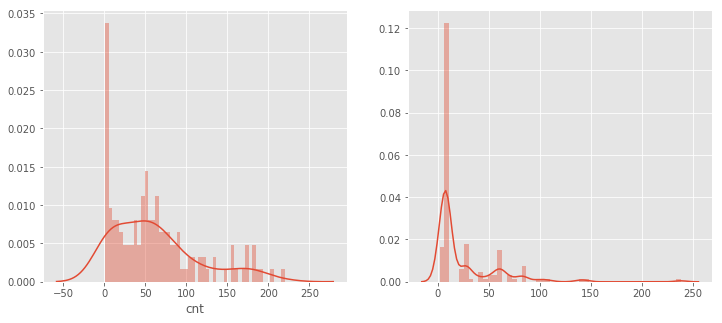

In [55]:
# here we plot our predictions' distribution vs. the actual distribution to estimate the goodness of the model.
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12, 5)
sns.distplot(y_test_sample, ax=ax1, bins=50)
sns.distplot((y_pred_combo), ax=ax2, bins=50)

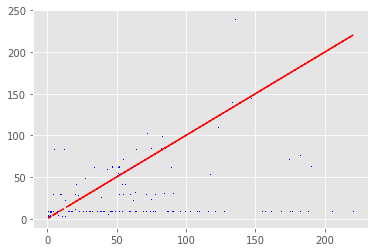

In [56]:
plt.plot(
    y_test_sample.compute(),
    y_test_sample.compute(),
    "r--",
    y_test_sample.compute(),
    y_pred_combo,
    "b,",
)
plt.show()

## Pipeline
Here we try to build a pipeline, where we figure out our best parameters for the logistic regression we run after it. 

In [57]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [58]:
steps = [("scaler", StandardScaler()), ("SVM", SVC())]
from sklearn.pipeline import Pipeline

pipeline = Pipeline(steps)  # define the pipeline object.

In [59]:
parameteres = {"SVM__C": [0.001, 0.1, 10, 100, 10e5], "SVM__gamma": [0.1, 0.01]}

In [60]:
grid = GridSearchCV(pipeline, param_grid=parameteres, cv=5)
grid

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SVM', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'SVM__C': [0.001, 0.1, 10, 100, 1000000.0], 'SVM__gamma': [0.1, 0.01]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [61]:
mod_start = time.time()
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings(action="ignore", category=DataConversionWarning)

with joblib.parallel_backend("dask"):
    grid.fit(X_train_sample.compute(), y_train_sample.compute())

    y_pred_pipe = grid.predict(X_test_sample)
    # here we measure the r^2
    r2_pipe = r2_score(y_test_sample.compute(), y_pred_combo)

    # here we measure the accuracy
    accuracy_pipe = cross_val_score(
        estimator=grid, X=X_test_sample.compute(), y=y_pred_combo, cv=3
    )
    accuracy_pipe = accuracy_pipe.mean()

mod_elapsed = time.time() - mod_start
df_results.loc[df_results.shape[0]] = [
    "SVM Pipe Dask",
    r2_pipe.round(2),
    accuracy_pipe.round(2),
    "",
    print_time(mod_elapsed),
]

df_results

C:\Users\ajukg\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\ajukg\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\ajukg\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\ajukg\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: Deprecation

,Model,score_cv,r^2,params,elapsed_time
0,LinearRegression,0,0.630000,,00:00:01
1,LinearRegression_cross_Val,0.68,0.630000,,00:00:00
2,RandomForestRegressor,0.72,0.850000,"{'max_features': 'auto', 'n_estimators': 200}",00:05:47
3,XGBRegressor_daskparallel_cv,0.79,0.900000,"{'colsample_bytree': 0.8, 'max_depth': 12, 'n_...",00:06:02
4,XGBRegressor_daskml,0.661747,0.661747,"[{'objective': 'reg:linear', 'random_state': 4...",00:00:10
5,rf gbm et_dask,-0.6,0.040000,,00:07:06
6,SVM Pipe Dask,-0.6,0.490000,,00:00:22


In [62]:
# Logistic Regression - Showing the Classification Report.
from sklearn.linear_model import LogisticRegression

logmodel = LogisticRegression(
    C=10,
    class_weight=None,
    dual=False,
    fit_intercept=True,
    intercept_scaling=1,
    max_iter=200,
    multi_class="ovr",
    n_jobs=1,
    penalty="l2",
    solver="liblinear",
    tol=0.0001,
    verbose=0,
    warm_start=False,
)

mod_start = time.time()

with joblib.parallel_backend("dask"):
    logmodel.fit(X_train_sample, y_train_sample)

    # Predicting on Test
    y_pred_pip_sample = logmodel.predict(X_test_sample)

    # here we measure the r^2
    r2_simple = r2_score(y_test_sample.compute(), y_pred_pip_sample)

    # here we measure the accuracy
    # Using r2 instead of accuracy.


mod_elapsed = time.time() - mod_start
df_results.loc[df_results.shape[0]] = [
    "Line Dask",
    r2_simple.round(2),
    r2_simple.round(2),
    "",
    print_time(mod_elapsed),
]

df_results

,Model,score_cv,r^2,params,elapsed_time
0,LinearRegression,0,0.630000,,00:00:01
1,LinearRegression_cross_Val,0.68,0.630000,,00:00:00
2,RandomForestRegressor,0.72,0.850000,"{'max_features': 'auto', 'n_estimators': 200}",00:05:47
3,XGBRegressor_daskparallel_cv,0.79,0.900000,"{'colsample_bytree': 0.8, 'max_depth': 12, 'n_...",00:06:02
4,XGBRegressor_daskml,0.661747,0.661747,"[{'objective': 'reg:linear', 'random_state': 4...",00:00:10
5,rf gbm et_dask,-0.6,0.040000,,00:07:06
6,SVM Pipe Dask,-0.6,0.490000,,00:00:22
7,Line Dask,-0.57,-0.570000,,00:00:01


Here we plot the distribution of the predictions and the actual distribution to see how similar they are. 

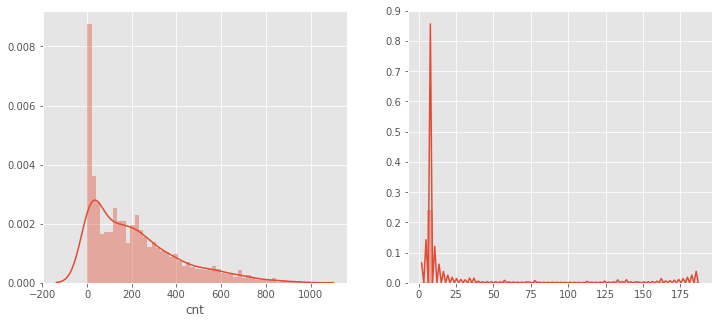

In [63]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12, 5)
sns.distplot(y_test, ax=ax1, bins=50)
sns.distplot((y_pred_pip_sample), ax=ax2, bins=50)

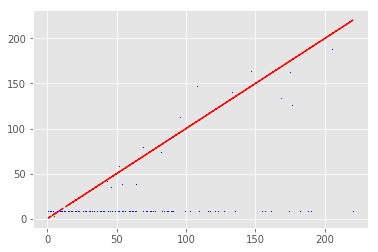

In [64]:
plt.plot(
    y_test_sample.compute(),
    y_test_sample.compute(),
    "r--",
    y_test_sample.compute(),
    y_pred_pip_sample,
    "b,",
)
plt.show()

## Wrap up
To sum up, here is once again the steps we went through: 
* **Step 1**: Exploratory data analysis: here we explore and get familiar with the data (graphically and numerically) 
    -  We plot the explanatory variables with the target variable to understand their relations graphically
* **Step 2**: Data cleaning: here we deal with outliers & NAs. 
   -  We change the class of certain variables to categorical to better fit our needs. Outliers did not need to be dropped as we get better results withouth this move. 
* **Step 3**: Feature engineering: we replace some of the columns with dummy columns in the right formats for our algorithms. 
* **Step 4**: Machine Learning: here we run different models individually, then we combine them and then we use a pipeline. 
    - Below a summary of the results of the various models

In [65]:
df_results

,Model,score_cv,r^2,params,elapsed_time
0,LinearRegression,0,0.630000,,00:00:01
1,LinearRegression_cross_Val,0.68,0.630000,,00:00:00
2,RandomForestRegressor,0.72,0.850000,"{'max_features': 'auto', 'n_estimators': 200}",00:05:47
3,XGBRegressor_daskparallel_cv,0.79,0.900000,"{'colsample_bytree': 0.8, 'max_depth': 12, 'n_...",00:06:02
4,XGBRegressor_daskml,0.661747,0.661747,"[{'objective': 'reg:linear', 'random_state': 4...",00:00:10
5,rf gbm et_dask,-0.6,0.040000,,00:07:06
6,SVM Pipe Dask,-0.6,0.490000,,00:00:22
7,Line Dask,-0.57,-0.570000,,00:00:01


As we can see, XGBoost tuned presents the best metrics by far. 

In [66]:
# here we plot the predictions of the various models against the actual values, so to compare them again.


def comparison_show_plots():

    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(27, 22))

    ax1 = axs[0, 0]

    ax1.plot(
        y_test.compute(), y_test.compute(), "r--", y_test.compute(), y_pred_rm, "b,"
    )
    ax1.set_title("Regression Model")

    ax2 = axs[0, 1]
    ax2.plot(
        y_test.compute(), y_test.compute(), "r--", y_test.compute(), y_pred_rfr, "b,"
    )
    ax2.set_title("Random Forest")

    ax1 = axs[1, 0]
    ax1.plot(
        y_test.compute(),
        y_test.compute(),
        "r--",
        y_test.compute(),
        y_pred_xgb_dsk.compute(),
        "b,",
    )
    ax1.set_title("XG Boost Dask Standard")

    ax2 = axs[1, 1]
    ax2.plot(
        y_test.compute(), y_test.compute(), "r--", y_test.compute(), y_pred_xgb, "b,"
    )
    ax2.set_title("XG Boost Tuned")

    plt.show()

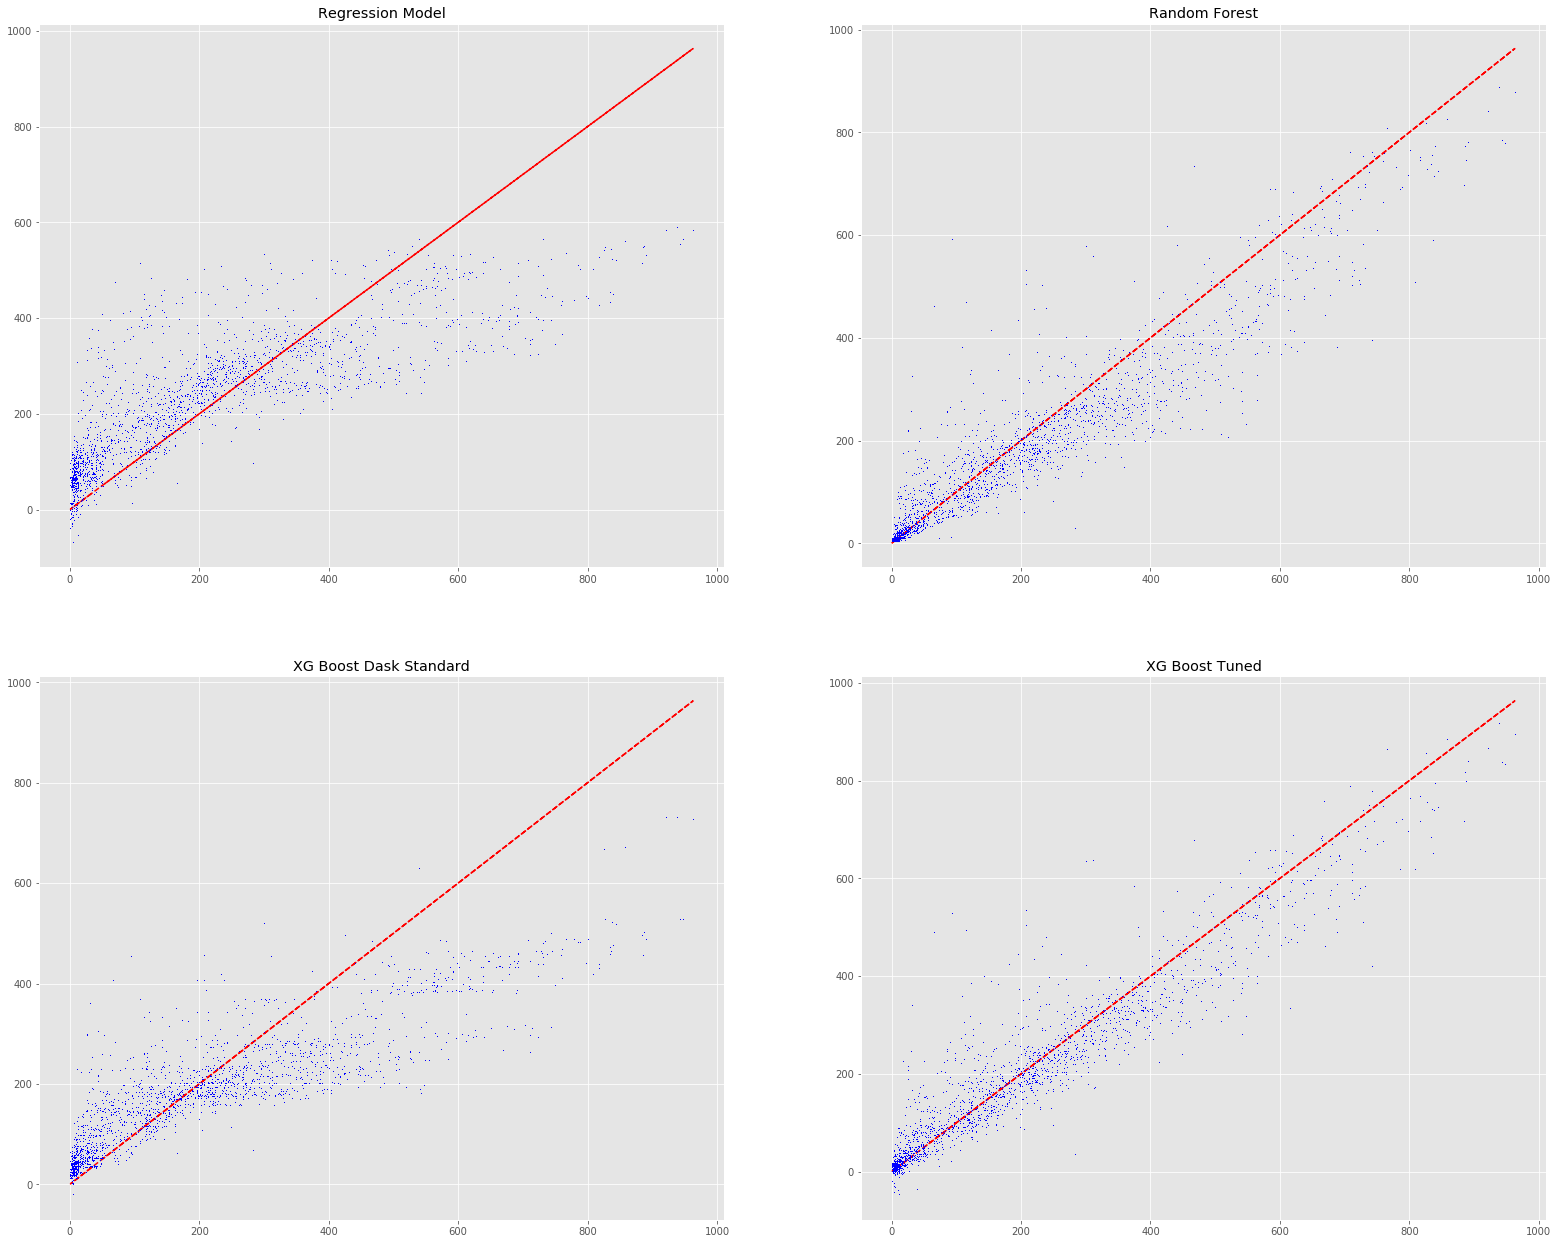

In [67]:
comparison_show_plots()

In [68]:
end_time = time.time()
elapsed = end_time - start

print("Start", print_time(start))
print("End", print_time(end_time))
print(print_time(elapsed))

# 00:22:17

Start 14:51:42
End 15:11:50
00:20:07


As we can clearly see, XGBoost after tuning reaches the best results. Compared to the other models, the performance is sensibly higher. The increase in the R^2 of the XGBoost, through hyperparameter tuning, was the turning point for best predictions. 